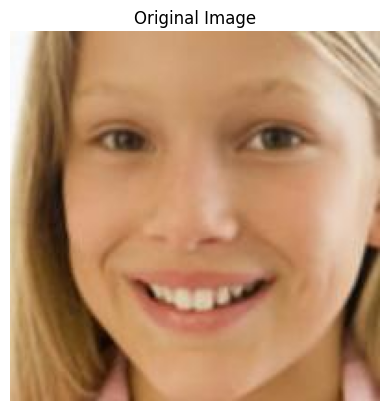

In [52]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt

# Load image
img_path = "images/img1.jpg"
image = cv2.imread(img_path)

# Check if image loaded
if image is None:
    print("Image not found! Check your path and filename.")
else:
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

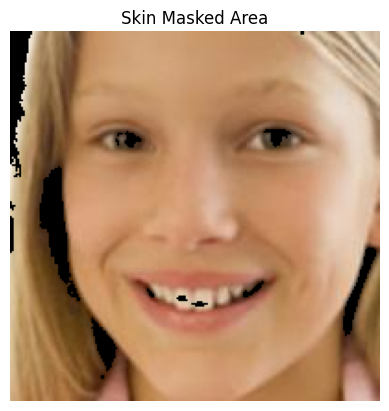

In [53]:
# Convert to HSV
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define lower and upper HSV bounds for skin color
lower_skin = (0, 20, 70)
upper_skin = (20, 255, 255)

# Create skin mask
skin_mask = cv2.inRange(image_hsv, lower_skin, upper_skin)

# Apply the mask to the original image
skin = cv2.bitwise_and(image, image, mask=skin_mask)
skin_rgb = cv2.cvtColor(skin, cv2.COLOR_BGR2RGB)  # Convert for display

# Display masked skin area
plt.imshow(skin_rgb)
plt.title("Skin Masked Area")
plt.axis("off")
plt.show()


NOTE: HSV-based skin detection was unable to isolate skin precisely, sometimes including hair, lips, or eyes. This reflects a major limitation in current tone detection methods and supports the need for more intelligent models.

ColorThief?
- Python library that grabs the most dominant color from an image.
- It works best with saved image files (not raw NumPy arrays), so we’ll temporarily save masked skin image before analyzing it.

In [55]:
from colorthief import ColorThief
import cv2
import tempfile
from PIL import Image

# Save the skin-masked image temporarily so ColorThief can read it
temp_file = tempfile.NamedTemporaryFile(suffix='.jpg', delete=False)
cv2.imwrite(temp_file.name, skin)

# Use ColorThief to get the dominant color
color_thief = ColorThief(temp_file.name)
dominant_rgb = color_thief.get_color(quality=1)

print("Dominant RGB skin color:", dominant_rgb)

Dominant RGB skin color: (190, 142, 103)


RGB to CIELAB Conversion
- RGB isn’t perceptually accurate — two colors with the same RGB difference can look very different to the human eye.
- CIELAB is designed to model how we actually perceive color, making it perfect for analyzing undertones.

In [56]:
from skimage import color
import numpy as np

# Convert the RGB tuple to a NumPy array and normalize it
rgb_array = np.array(dominant_rgb) / 255.0
rgb_array = rgb_array.reshape((1, 1, 3))  # Shape: (1, 1, 3)

# Convert to CIELAB using skimage
lab_color = color.rgb2lab(rgb_array)

# Extract L*, a*, b*
l, a, b = lab_color[0, 0]

print(f"CIELAB values:\nL* = {l:.2f}, a* = {a:.2f}, b* = {b:.2f}")

CIELAB values:
L* = 62.74, a* = 13.30, b* = 27.83


In [67]:
# Load the ground truth labels
df = pd.read_csv("undertone_labels.csv")
df["ground_truth_undertone"] = df["ground_truth_undertone"].str.strip().str.lower()

# Create lists to collect labels
actuals = []
predictions = []


In [82]:
actuals = []
predictions = []
lab_points = []

for index, row in df.iterrows():
    img_name = row["image_name"]
    actual = row["ground_truth_undertone"]
    img_path = os.path.join("images", img_name)  # adjust folder name if needed

    if not os.path.exists(img_path):
        print(f"Missing image: {img_name}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        print(f"Unable to read: {img_name}")
        continue

    # Mask skin region
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_skin = (0, 20, 70)
    upper_skin = (20, 255, 255)
    skin_mask = cv2.inRange(image_hsv, lower_skin, upper_skin)
    skin = cv2.bitwise_and(image, image, mask=skin_mask)

    # Save temp image for ColorThief
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.jpg')
    cv2.imwrite(temp_file.name, skin)

    try:
        color_thief = ColorThief(temp_file.name)
        dominant_rgb = color_thief.get_color(quality=1)
    except:
        print(f"ColorThief failed: {img_name}")
        continue

    # Convert RGB to LAB
    rgb_array = np.array(dominant_rgb) / 255.0
    rgb_array = rgb_array.reshape((1, 1, 3))
    lab = color.rgb2lab(rgb_array)
    _, a, b = lab[0, 0]

    # Rule-based logic 
    if a >= 12 and a > b:
        undertone = "cool"
    elif b >= 16 and b > a:
        undertone = "warm"
    elif 10 <= a <= 16 and 13 <= b <= 20:
        undertone = "neutral"
    else:
        undertone = "unclassified"

    # Debug (optional)
    print(f"{img_name}: a={a:.2f}, b={b:.2f} → Predicted: {undertone}, Actual: {actual}")

    # Save to lists
    actuals.append(actual.strip().lower())
    predictions.append(undertone.strip().lower())
    lab_points.append((a, b, actual.strip().lower(), undertone.strip().lower()))


img1.jpg: a=13.30, b=27.83 → Predicted: warm, Actual: warm
img2.jpg: a=6.43, b=11.48 → Predicted: unclassified, Actual: cool
img3.jpg: a=16.30, b=15.07 → Predicted: cool, Actual: neutral
img4.jpg: a=10.64, b=13.36 → Predicted: neutral, Actual: neutral
img5.jpg: a=13.44, b=17.72 → Predicted: warm, Actual: warm
img6.jpg: a=-0.00, b=0.00 → Predicted: unclassified, Actual: cool
img7.jpg: a=13.92, b=26.32 → Predicted: warm, Actual: warm
img8.jpg: a=18.60, b=29.65 → Predicted: warm, Actual: warm
img9.jpg: a=11.00, b=22.79 → Predicted: warm, Actual: neutral
img10.jpg: a=3.24, b=3.81 → Predicted: unclassified, Actual: neutral
img11.jpg: a=21.84, b=27.26 → Predicted: warm, Actual: warm
img12.jpg: a=8.10, b=17.19 → Predicted: warm, Actual: cool
img13.jpg: a=10.65, b=14.86 → Predicted: neutral, Actual: cool
img14.jpg: a=8.43, b=27.81 → Predicted: warm, Actual: warm
img15.jpg: a=17.71, b=23.94 → Predicted: warm, Actual: warm
img16.jpg: a=13.72, b=23.93 → Predicted: warm, Actual: neutral
img17.jpg:


Evaluating COOL
Actual 1s: 10
Predicted 1s: 2


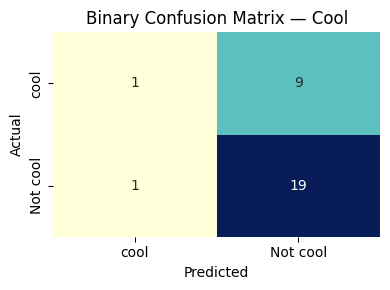


Evaluating WARM
Actual 1s: 11
Predicted 1s: 17


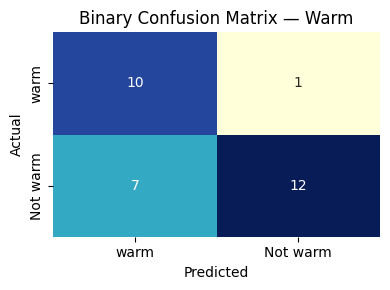


Evaluating NEUTRAL
Actual 1s: 8
Predicted 1s: 4


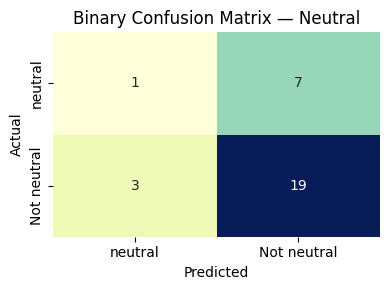

In [84]:
# Normalize just in case
actuals = [a.strip().lower() for a in actuals]
predictions = [p.strip().lower() for p in predictions]

# Define classes to evaluate
labels = ["cool", "warm", "neutral"]

for target_class in labels:
    binary_actuals = [1 if label == target_class else 0 for label in actuals]
    binary_preds = [1 if label == target_class else 0 for label in predictions]

    print(f"\nEvaluating {target_class.upper()}")
    print("Actual 1s:", sum(binary_actuals))
    print("Predicted 1s:", sum(binary_preds))

    if sum(binary_actuals) == 0 and sum(binary_preds) == 0:
        print(f"Skipping {target_class} — no data.")
        continue

    cm = confusion_matrix(binary_actuals, binary_preds, labels=[1, 0])

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", cbar=False,
                xticklabels=[f"{target_class}", f"Not {target_class}"],
                yticklabels=[f"{target_class}", f"Not {target_class}"])
    plt.title(f"Binary Confusion Matrix — {target_class.capitalize()}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()


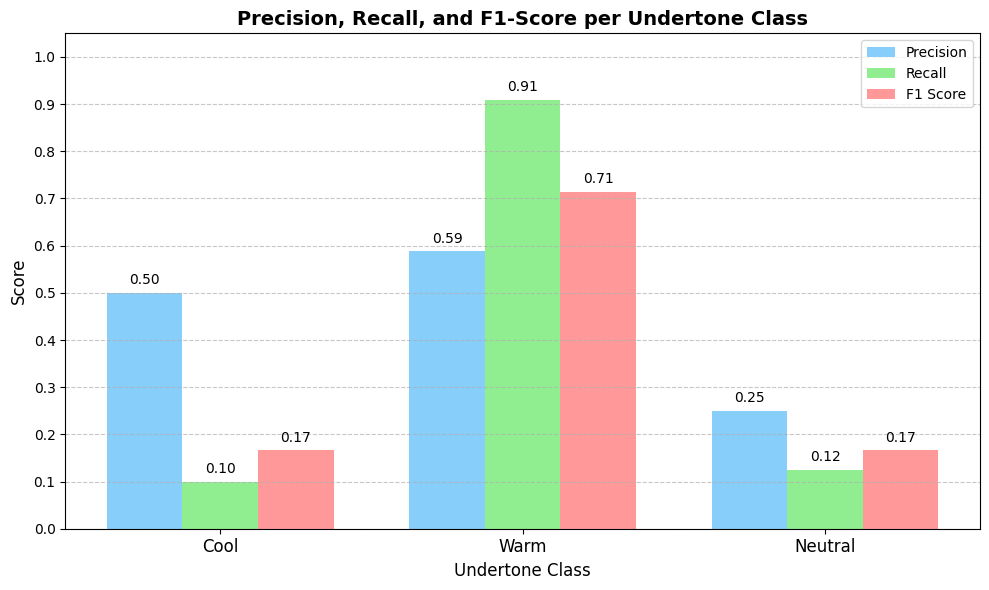

Classification Metrics:
Class      Precision  Recall     F1 Score   Support
Cool       0.50       0.10       0.17       10
Warm       0.59       0.91       0.71       11
Neutral    0.25       0.12       0.17       8

Overall Accuracy: 40.00%


In [85]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Get per-class scores
precision, recall, f1, support = precision_recall_fscore_support(
    actuals, predictions, labels=["cool", "warm", "neutral"], zero_division=0
)

classes = ["Cool", "Warm", "Neutral"]
x = np.arange(len(classes))
width = 0.25

# Overall accuracy
accuracy = accuracy_score(actuals, predictions)

# Create figure
plt.figure(figsize=(10, 6))
bar1 = plt.bar(x - width, precision, width=width, label='Precision', color='#87CEFA')
bar2 = plt.bar(x, recall, width=width, label='Recall', color='#90EE90')
bar3 = plt.bar(x + width, f1, width=width, label='F1 Score', color='#FF9999')

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}",
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 4),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

# Customizing plot
plt.xticks(x, classes, fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim(0, 1.05)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Undertone Class", fontsize=12)
plt.title("Precision, Recall, and F1-Score per Undertone Class", fontsize=14, weight='bold')
plt.legend(loc="upper right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print detailed metrics in table form
print("Classification Metrics:")
print(f"{'Class':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10} {'Support'}")
for i, cls in enumerate(classes):
    print(f"{cls:<10} {precision[i]:<10.2f} {recall[i]:<10.2f} {f1[i]:<10.2f} {support[i]}")

# Overall accuracy
print(f"\nOverall Accuracy: {accuracy * 100:.2f}%")


# CONCLUSION:
### Out of 30 evaluated images, the rule-based pipeline achieved only 40% accuracy. The majority of undertones were misclassified or not classified at all. These results confirm that traditional skin tone detection tools, even when enhanced with color space conversion, are insufficient for accurate undertone detection. This motivates our proposed deep learning model.

### Plotting the Results
- #### Extract and store the a*, b*, and ground truth undertone for all images
- #### Then plot their distribution in CIELAB space

/var/folders/gz/kzywvj9n13ngr91qfsl5_ky00000gn/T/ipykernel_22270/1297604359.py:17: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(a, b, c='blue', marker=marker(pred), edgecolor='black', s=100, label='Cool')
/var/folders/gz/kzywvj9n13ngr91qfsl5_ky00000gn/T/ipykernel_22270/1297604359.py:23: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(a, b, c='green', marker=marker(pred), edgecolor='black', s=100, label='Neutral')


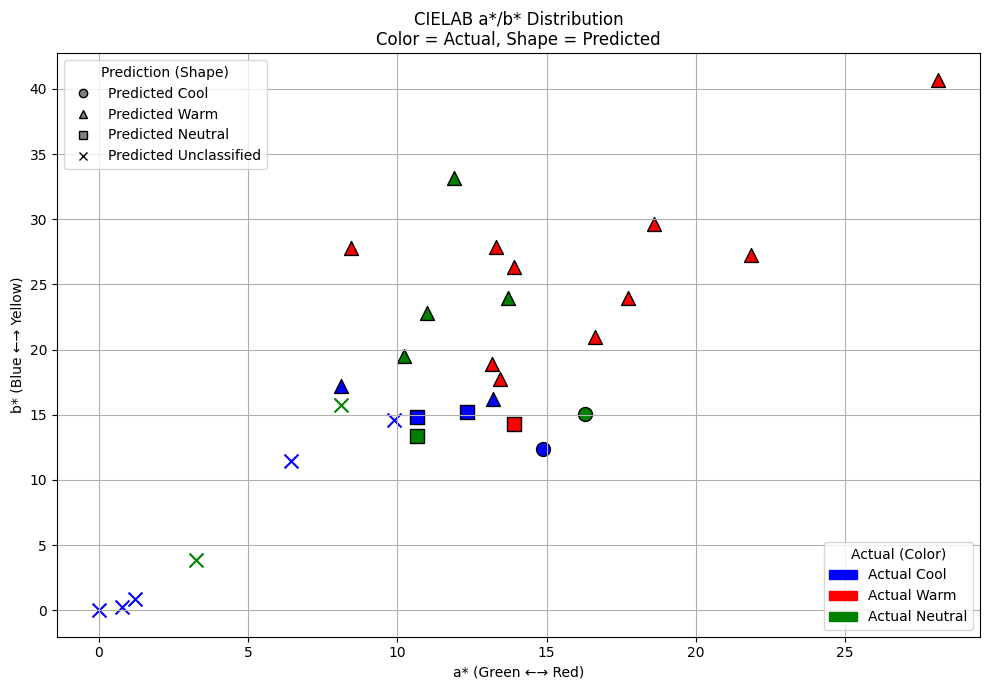

In [86]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Group points by actual label
cool = [(a, b, pred) for (a, b, act, pred) in lab_points if act == "cool"]
warm = [(a, b, pred) for (a, b, act, pred) in lab_points if act == "warm"]
neutral = [(a, b, pred) for (a, b, act, pred) in lab_points if act == "neutral"]

plt.figure(figsize=(10, 7))

# Shape = predicted undertone
def marker(pred): 
    return 'o' if pred == 'cool' else '^' if pred == 'warm' else 's' if pred == 'neutral' else 'x'

# Plot each class with color = actual label, shape = predicted label
for a, b, pred in cool:
    plt.scatter(a, b, c='blue', marker=marker(pred), edgecolor='black', s=100, label='Cool')

for a, b, pred in warm:
    plt.scatter(a, b, c='red', marker=marker(pred), edgecolor='black', s=100, label='Warm')

for a, b, pred in neutral:
    plt.scatter(a, b, c='green', marker=marker(pred), edgecolor='black', s=100, label='Neutral')

# Labels
plt.xlabel("a* (Green ←→ Red)")
plt.ylabel("b* (Blue ←→ Yellow)")
plt.title("CIELAB a*/b* Distribution\nColor = Actual, Shape = Predicted")
plt.grid(True)

# Legend: Shapes = prediction
legend_shapes = [
    plt.Line2D([0], [0], marker='o', color='w', label='Predicted Cool', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='^', color='w', label='Predicted Warm', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='s', color='w', label='Predicted Neutral', markerfacecolor='gray', markeredgecolor='black'),
    plt.Line2D([0], [0], marker='x', color='black', label='Predicted Unclassified', linestyle='None'),
]

# Legend: Colors = actual
legend_colors = [
    mpatches.Patch(color='blue', label='Actual Cool'),
    mpatches.Patch(color='red', label='Actual Warm'),
    mpatches.Patch(color='green', label='Actual Neutral'),
]

# Combine legends
first_legend = plt.legend(handles=legend_shapes, title="Prediction (Shape)", loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=legend_colors, title="Actual (Color)", loc='lower right')

plt.tight_layout()
plt.show()


### This scatter plot shows how skin samples are distributed in CIELAB a*/b* space. The color of each point represents the actual undertone label (cool, warm, neutral), while the shape indicates the prediction by our rule-based system. The frequent mismatches between color and shape illustrate the limitations of fixed-threshold logic for undertone classification.